In [44]:
# 必須先安裝: pip install numpy torch torchvision scikit-learn matplotlib pillow tqdm

%matplotlib inline
import os, random, csv, colorsys, numpy as np, torch
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from sklearn.metrics import precision_recall_curve, average_precision_score
from torch.utils.data import Dataset, DataLoader, Subset, random_split

# 你的四種模型
from Depth4UNet          import UNet11_4ch as UNet11_ReLU   # RGBD (VGG11+ReLU)
from Depth4UNetGELU      import UNet11_4ch as UNet11_GELU  # RGBD (VGG11+GELU)
from UNet                import UNet_4ch   as UNet4_RGBD   # RGBD (原生 U-Net)
from UNetVGG11           import UNet11     as UNet11_RGB   # RGB  (VGG11)

ARCHES = {
    "unet4_rgbd" : dict(cls=UNet4_RGBD,  in_ch=4),
    "vgg11_relu" : dict(cls=UNet11_ReLU, in_ch=4),
    "vgg11_gelu" : dict(cls=UNet11_GELU, in_ch=4),
    "vgg11_rgb"  : dict(cls=UNet11_RGB,  in_ch=3),
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [45]:
class _BaseDS(Dataset):
    def __init__(self, root, crop=256):
        root = Path(root)
        self.crop = crop
        self.img_dir, self.mask_dir = root / "images", root / "gt"
        self.names = sorted(os.listdir(self.img_dir))
    def _crop(self,*arrs):
        h,w = arrs[0].shape[:2]; ch=cw=self.crop
        top, left = random.randint(0,h-ch), random.randint(0,w-cw)
        return [a[top:top+ch,left:left+cw] for a in arrs]

class DS_RGB(_BaseDS):
    MEAN = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    STD  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    def __getitem__(self,i):
        n=self.names[i]
        rgb = np.asarray(Image.open(self.img_dir/n).convert("RGB"))
        msk = np.asarray(Image.open(self.mask_dir/n).convert("L"))
        rgb,msk=self._crop(rgb,msk)
        rgb=torch.from_numpy(rgb).permute(2,0,1).float()/255.0
        msk=(torch.from_numpy(msk)//255).float().unsqueeze(0)
        rgb=(rgb-self.MEAN)/self.STD
        return rgb,msk

class DS_RGBD(_BaseDS):
    MEAN = torch.tensor([0.485,0.456,0.406,0.5]).view(4,1,1)
    STD  = torch.tensor([0.229,0.224,0.225,0.5]).view(4,1,1)
    def __init__(self,root,crop=256):
        super().__init__(root,crop)
        self.depth_dir = Path(root)/"depth_images"
        self.dmap={f[:-6]:f for f in os.listdir(self.depth_dir) if f.endswith("_depth.png")}
    def __getitem__(self,i):
        n=self.names[i]; stem,_=os.path.splitext(n)
        rgb = np.asarray(Image.open(self.img_dir/n).convert("RGB"))
        depth = np.asarray(Image.open(self.depth_dir/self.dmap.get(stem,"")).convert("L")) \
                if stem in self.dmap else np.zeros(rgb.shape[:2],np.uint8)
        msk = np.asarray(Image.open(self.mask_dir/n).convert("L"))
        rgb,depth,msk=self._crop(rgb,depth[...,None],msk)
        rgb=torch.from_numpy(rgb).permute(2,0,1).float()/255.0
        depth=torch.from_numpy(depth).permute(2,0,1).float()/255.0
        x=torch.cat([rgb,depth],0); x=(x-self.MEAN)/self.STD
        msk=(torch.from_numpy(msk)//255).float().unsqueeze(0)
        return x,msk
    def __len__(self): return len(self.names)



In [46]:
# ✅ 修改成你的實際路徑
ROOT = r"E:/論文/空拍地圖語意分割/Depth4UNet/AerialImageDataset/train"
VAL_IDX_NPY = "val_idx.npy"   # 首次執行會自動產生
CHECKPOINTS = [
    (r"E:/論文/空拍地圖語意分割/Depth4UNet/checkpoints/best_traditional_unet4ch.pth",  "UNet4",       "unet4_rgbd"),
    (r"E:/論文/空拍地圖語意分割/Depth4UNet/checkpoints/best_unet4ch(new).pth",  "VGG11_ReLU",  "vgg11_relu"),
    (r"E:/論文/空拍地圖語意分割/Depth4UNet/checkpoints/best_unet4ch(GELU_Inverted Bottleneck).pth",  "VGG11_GELU",  "vgg11_gelu"),
    (r"E:/論文/空拍地圖語意分割/Depth4UNet/checkpoints/best_unet.pth",   "RGB_VGG11",   "vgg11_rgb"),
]
BATCH_SIZE = 4


In [49]:
def get_loader(root, in_ch, idx_file, crop=256, bs=4):
    base = DS_RGBD if in_ch==4 else DS_RGB
    full = base(root,crop)
    if os.path.exists(idx_file):
        idx = np.load(idx_file); val_ds=Subset(full,idx)
    else:
        v=int(0.1*len(full))
        _,val_ds=random_split(full,[len(full)-v,v],generator=torch.Generator().manual_seed(0))
        np.save(idx_file, np.array(val_ds.indices))
    return DataLoader(val_ds,batch_size=bs,shuffle=False,num_workers=0)

import torch.nn as nn

def add_missing_bias(module: nn.Module):
    """
    遍歷整個 model，若某個 nn.Conv2d / nn.ConvTranspose2d 沒有 bias，
    就動態加上一個零初始化的 bias 參數，使其能對應舊 checkpoint。
    """
    for name, m in module.named_modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)) and m.bias is None:
            b = nn.Parameter(torch.zeros(m.out_channels, device=m.weight.device))
            m.register_parameter("bias", b)      # 動態掛進 module
            # 注意：不用修改 m.register_parameter 的 return 值


C:\Users\op237\AppData\Local\Temp\ipykernel_24532\1315762412.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_all  = torch.load(ckpt, map_location=device)


UNet4: matched 46 / 46 layers


c:\Users\op237\miniconda3\envs\Depth4UNet\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\op237\miniconda3\envs\Depth4UNet\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\op237\AppData\Local\Temp\ipykernel_24532\1315762412.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pyt

VGG11_ReLU: matched 43 / 56 layers


KeyboardInterrupt: 

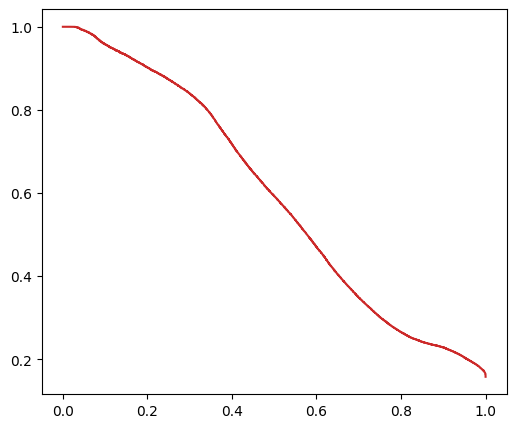

In [ ]:
# PR 曲線顏色
def palette(n): return [colorsys.hsv_to_rgb(i/n,0.8,0.8) for i in range(n)]

loaders = {}
plt.figure(figsize=(6,5))
for (ckpt, label, arch), color in zip(CHECKPOINTS, palette(len(CHECKPOINTS))):
    info  = ARCHES[arch]
    if info["in_ch"] not in loaders:
        loaders[info["in_ch"]] = get_loader(ROOT, info["in_ch"], VAL_IDX_NPY, crop=256, bs=BATCH_SIZE)
    ld = loaders[info["in_ch"]]

    # 1. 建模型
    model = info["cls"]().to(device)
    add_missing_bias(model)      
    # 2. 手動對齊權重（方案 B）
    state_all  = torch.load(ckpt, map_location=device)
    model_state = model.state_dict()
    compatible = {k: v for k, v in state_all.items()
                  if k in model_state and v.shape == model_state[k].shape}
    model_state.update(compatible)
    model.load_state_dict(model_state)   # strict=True 預設
    print(f"{label}: matched {len(compatible)} / {len(model_state)} layers")

    # 3. 評估
    y_true, y_score = [], []
    with torch.no_grad():
        for x, y in ld:
            y_score.append(torch.sigmoid(model(x.to(device))).cpu())
            y_true.append(y)
    y_true  = torch.cat(y_true).numpy().ravel()
    y_score = torch.cat(y_score).numpy().ravel()

    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    plt.plot(recall, precision, color=color, label=f"{label} (AP={ap:.3f})")



plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("PR curves (val set)")
plt.grid(); plt.legend(); plt.tight_layout()


In [ ]:
print(CHECKPOINTS)


[('E:/論文/空拍地圖語意分割/Depth4UNet/checkpoints/best_traditional_unet4ch.pth', 'UNet4', 'unet4_rgbd'), ('E:/論文/空拍地圖語意分割/Depth4UNet/checkpoints/best_unet4ch.pth', 'VGG11_ReLU', 'vgg11_relu'), ('E:/論文/空拍地圖語意分割/Depth4UNet/checkpoints/best_unet4ch(GELU_Inverted Bottleneck).pth', 'VGG11_GELU', 'vgg11_gelu'), ('E:/論文/空拍地圖語意分割/Depth4UNet/checkpoints/best_unet.pth', 'RGB_VGG11', 'vgg11_rgb')]
